<a href="https://colab.research.google.com/github/namita0210/Audio-data-analysis-with-pytorch/blob/main/Exploring_inbuilt_audio_%26_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import IPython as ipd
import torch.optim as optim
import sys
from tqdm import tqdm
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import torchaudio.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu121
2.1.0+cu121


Load the data

In [2]:
os.makedirs('data' , exist_ok=True)

In [3]:
data = datasets.SPEECHCOMMANDS(root='data', download=True)
print(data)

100%|██████████| 2.26G/2.26G [00:56<00:00, 42.7MB/s]


Split the data - train , test , validate

In [5]:
class SubsetSC(data):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [6]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [00:57<00:00, 42.4MB/s]


Explore the data

In [7]:
sample, sample_rate, label,speaker_id,utterance_number = train_set[0]
print(f'''
Tensor waveform of audio sample: {sample}
Sample rate: {sample_rate}
Label: {label}
Speaker ID: {speaker_id}
Utterance number: {utterance_number}
''')


Tensor waveform of audio sample: tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])
Sample rate: 16000
Label: backward
Speaker ID: 0165e0e8
Utterance number: 0



In [11]:
num_samples = len(train_set)
print(f"Number of samples in training set: {num_samples}")

num_samples_test = len(test_set)
print(f"Number of samples in test set: {num_samples_test}")

total_num_samples = len(data)
print(f"Number of samples in total data set: {total_num_samples}")

Number of samples in training set: 84843
Number of samples in test set: 11005
Number of samples in total data set: 105829


In [12]:
#shape of the tensor
sample.shape

torch.Size([1, 16000])

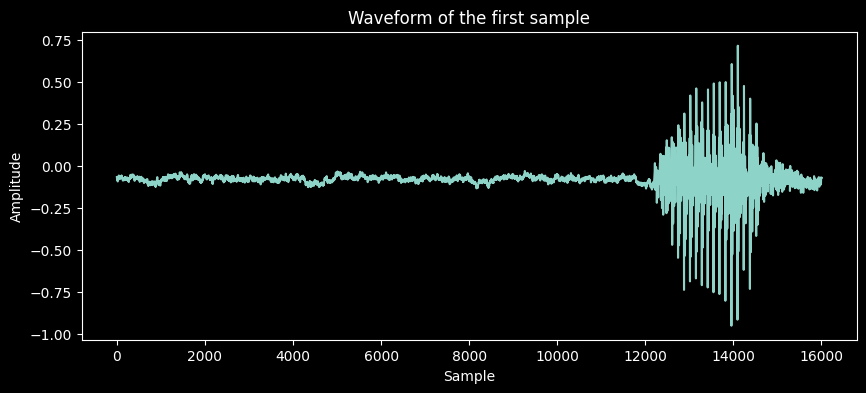

In [13]:
#Waveform of first sample
plt.style.use('dark_background')
plt.figure(figsize=(10,4))
plt.plot(sample.t().numpy()) #transform leke numpy me convert krke plot krdiya
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform of the first sample')
plt.show()

In [ ]:
unique_labels = set()
for waveform, _, label , _ , _ in data:
  unique_labels.add(label)

print(unique_labels)
#{'bed', 'wow', 'seven', 'eight', 'left', 'marvin', 'one', 'three', 'go', 'nine', 'stop', 'dog', 'on', 'up', 'sheila', 'house', 'right', 'zero', 'backward', 'happy', 'bird', 'off', 'six', 'tree', 'four', 'cat', 'follow', 'forward', 'learn', 'five', 'yes', 'down', 'two', 'no', 'visual'}

In [23]:
labels = ['bed', 'wow', 'seven', 'eight', 'left', 'marvin', 'one', 'three', 'go', 'nine', 'stop', 'dog', 'on', 'up', 'sheila', 'house', 'right', 'zero', 'backward', 'happy', 'bird', 'off', 'six', 'tree', 'four', 'cat', 'follow', 'forward', 'learn', 'five', 'yes', 'down', 'two', 'no', 'visual' ]
labels = sorted(labels)
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [15]:
waveform_first, *_ = train_set[0]
ipd.display.Audio(waveform_first.numpy(), rate=sample_rate)

In [16]:
waveform_second, *_ = train_set[1]
ipd.display.Audio(waveform_second.numpy(), rate=sample_rate)

In [17]:
waveform_last, *_ = train_set[-1]
ipd.display.Audio(waveform_last.numpy(), rate=sample_rate)

In [21]:
ipd.display.Audio(sample.numpy(), rate=sample_rate)

In [20]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(sample)
ipd.display.Audio(transformed.numpy(), rate=new_sample_rate)

Encoding each word using its index in the list of labels

In [24]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


yes --> tensor(33) --> yes


In [25]:
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)
print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [ ]:
def plot_specgram(waveform, sample_rate, title='Spectrogram'):
    waveform = waveform.numpy()
    plt.figure(figsize=(10, 4))
    plt.specgram(waveform[0], Fs=sample_rate)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar().set_label('Intensity (dB)')
    plt.show()


In [ ]:
i = 1
print(data[i])

(tensor([[-0.0003, -0.0002, -0.0005,  ...,  0.0005,  0.0007,  0.0010]]), 16000, 'backward', '017c4098', 0)


In [ ]:
label = (data[0][2])
waveform = data[0][0]
sample_rate = data[0][1]

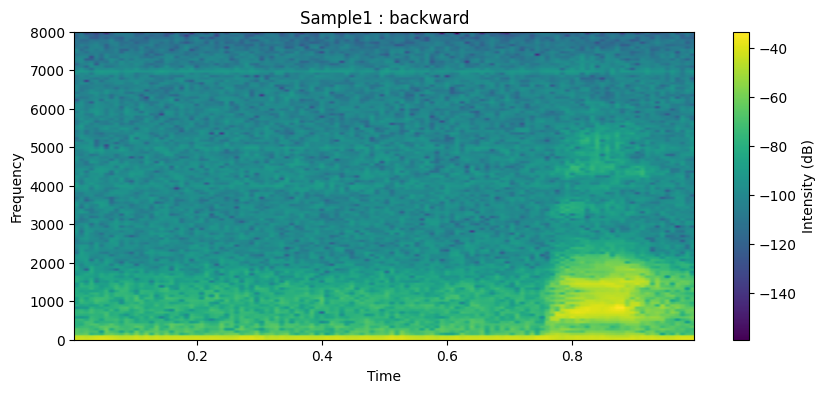

In [ ]:
plot_specgram(waveform , sample_rate , title = f"Sample{i} : {label}")
ipd.display.Audio(waveform, rate = sample_rate)

Get the distribution of labels in the dataset to check for class imbalance.
Iterate over the dataset and count the occurence of each label

{'bed', 'wow', 'seven', 'eight', 'left', 'marvin', 'one', 'three', 'go', 'nine', 'stop', 'dog', 'on', 'up', 'sheila', 'house', 'right', 'zero', 'backward', 'happy', 'bird', 'off', 'six', 'tree', 'four', 'cat', 'follow', 'forward', 'learn', 'five', 'yes', 'down', 'two', 'no', 'visual'}
